#####Import Required Libraries

In [0]:
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
from numpy import mean, absolute
from sklearn.metrics import r2_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
from scipy import stats
from sklearn.svm import SVR

#####Load Dataset

In [0]:
# loading the dataset
data = read_csv("./forestfires.csv")

##### Encoding Months and Days

In [0]:
encode_months = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 
                 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 
                 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
encode_days = {'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 
               'fri': 5, 'sat': 6, 'sun': 7 }
data = data.replace({'month': encode_months, 'day': encode_days});

Split data into input (X) and output (Y) variables

In [0]:
X = data.iloc[:,0:12]
Y = data.iloc[:,12].values

##### Standardisation of Inputs

In [0]:
def standardData(z, mean, std): 
    z_standard = (z - mean)/ std
    return z_standard

X = standardData(X,X.mean(),X.std())

##Pre-Processing Techniques Used:

###Determining Feature Weightage Using ExtraTreesClassifier:

Values of Weightage is divided in a manner that it will all sum up to 1 and Printing the rank of features:

In [0]:
def ExtraTreesClassifier(X,Y):
  Y=Y.astype(int)

  # load the dataset
  dataset = X

  # fit an Extra Trees model to the data
  model= ExtraTreesRegressor(n_estimators=10000, n_jobs=-1, random_state=1)
  model.fit(X,Y)


  importances = model.feature_importances_
  std = np.std([tree.feature_importances_ for tree in model.estimators_],
              axis=0)
  indices = np.argsort(importances)[::-1]
  cols= [col for col in range(X.shape[1]) if importances[col]>=0.1]
  newX=X[X.columns[cols]]
  
  # Plot the feature importances: 
  plt.figure()
  plt.title("Feature Importance Ranking")
  plt.xlabel('Feature Number')
  plt.ylabel('Feature Weightage')
  plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
  plt.xticks(range(X.shape[1]), indices)
  plt.xlim([-1, X.shape[1]])
  plt.show()
  print("ExtraTreesClassifier run succesfully. %.2f Features extracted." % newX.shape[1])
  return newX

###Feature selection using Principal Component Analysis:

In [0]:
#Retaining 95% of data post PCA.
def enable_pca(X):
  pca = PCA(.95)
  pca.fit(X)
  X_pca = pca.transform(X)
  print("PCA run succesfully. %.2f Features extracted." % X_pca.shape[1])
  return X_pca

Splitting data into Training and Testing sets

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,shuffle=False )

## Function for Negative Log Likelihood

In [0]:
def NLL(Y,Y_pred):
  n=Y.shape[0]
  variance = np.var(Y_pred, ddof=1)
  first_term= (n/2)*np.log(2*np.pi*variance)
  second_term=0
  for i in range(n):
    second_term+= (Y[i]-Y_pred[i])**2 
  second_term=second_term/(2*variance)
  NLL = first_term+second_term
  return NLL

#REGRESSION MODELS

###Function for Linear Regression Model

In [0]:
def LinearRegressionModel(): 
  LR = LinearRegression().fit(X_train, y_train)
  y_pred = LR.predict(X_test)
  print("Linear Regression")
  return y_pred

### Function for K Neighbors Regression model

In [0]:
def KNR():
  K=4
  KNR = KNeighborsRegressor(n_neighbors=K)
  KNR.fit(X_train, y_train)
  y_pred = KNR.predict(X_test) 
  print("K Nearest Regression")
  return y_pred

### Function for Decision Tree model

In [0]:
def DecisionTree():  
  DTR = DecisionTreeRegressor(random_state=0)
  DTR.fit(X_train, y_train)
  y_pred = DTR.predict(X_test)
  print("Decision Tree Regression")
  return y_pred

### Function for AdaBoost Regressor Model

In [0]:
def AdaBoost():
  AdB = AdaBoostRegressor(random_state=0, n_estimators=100, loss='square', learning_rate=1)
  AdB.fit(X_train, y_train)
  y_pred = AdB.predict(X_test)
  print("AdaBoost Regression")
  return y_pred

### Function for the Deep Learning model

In [0]:
def DeepLearning():
	# define the base_line_model
	def baseline_model():
		# create model
		model = Sequential()
		model.add(Dense(20, kernel_initializer='normal', activation='relu'))
		model.add(Dense(10, kernel_initializer='normal', activation='relu'))
		model.add(Dense(3, kernel_initializer='normal', activation='relu'))
		model.add(Dense(1, kernel_initializer='normal'))
		# Compile model
		model.compile(loss='mean_squared_error', optimizer='adam')
		return model
	# evaluate model with standardized dataset
	estimators = []
	estimators.append(('standardize', StandardScaler()))
	estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
	pipeline = Pipeline(estimators)
	kfold = KFold(n_splits=10)
	results = cross_val_score(pipeline, X, Y, cv=kfold,scoring='neg_mean_squared_error')
	y_pred = cross_val_predict(pipeline, X, Y, cv=kfold)
	print("Deep Learning \nStandardized: %.2f \n(%.2f) RMSE" % (results.mean(), np.sqrt(results.std())))
	print("Negative Log Likelihood is: ",NLL(Y,y_pred))
	print("Mean Absolute Deviation is:" ,mean(absolute(y_pred - mean(y_pred))))

### Function for the Random Forest Model

In [0]:
def RandomForest():
  RF = RandomForestRegressor(oob_score=True, n_estimators=20, min_samples_split=10, random_state=100)
  RF.fit(X_train, y_train)
  y_pred = RF.predict(X_test)
  print("Random Forest Regression")
  return y_pred

### Function for the Support Vector Regressor Model

In [0]:
def SupportVectorRegressor():
  SVM = SVR(kernel='linear',degree=1)
  SVM.fit(X_train,y_train)
  y_pred = SVM.predict(X_test)
  print("Support Vector Machine")
  return y_pred

#Menu driven program to run the Desired Model :



Enter Choice for Feature Selection (1-3):
1. Use Nothing
2. Use PCA
3. Use ExtraTreesClassifier 
3


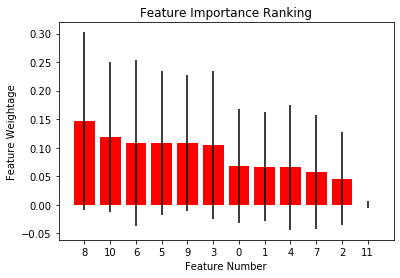

ExtraTreesClassifier run succesfully. 6.00 Features extracted.
Enter Choice for model selection(1-7):
1. Deep Learning
2. Random Forest
3. Support Vector Regressor
4. Linear Regression
5. K Nearest Regressor
6. Decision Tree
7. AdaBoost 
4
Linear Regression
Root Mean Square Error is: 67.73605752995044
Mean Absolute Error is: 27.61353460599714
Mean Absolute Deviation is: 13.714317744643576
Negative Log Likelihood is:  1657.5734103816858


In [515]:
inp= input("Enter Choice for Feature Selection (1-3):\n1. Use Nothing\n2. Use PCA\n3. Use ExtraTreesClassifier \n")
inp= int(inp)
if inp is 2:
  X= enable_pca(X)
elif inp is 3:
  X= ExtraTreesClassifier(X,Y)  
val= input("Enter Choice for model selection(1-7):\n1. Deep Learning\n2. Random Forest\n3. Support Vector Regressor\n4. Linear Regression\n5. K Nearest Regressor\n6. Decision Tree\n7. AdaBoost \n")
val = int(val)
if val is 1:
  DeepLearning()
elif val is 2:
  y_pred = RandomForest()
elif val is 3:
  y_pred = SupportVectorRegressor()
elif val is 4:
  y_pred = LinearRegressionModel()
elif val is 5:
  y_pred = KNR()
elif val is 6:
  y_pred = DecisionTree()
elif val is 7:
  y_pred = AdaBoost()

if val >1 and val<8:
  print("Root Mean Square Error is:" , np.sqrt(mse(y_test,y_pred)))
  print("Mean Absolute Error is:" , mae(y_test,y_pred))
  print("Mean Absolute Deviation is:" ,mean(absolute(y_pred - mean(y_pred))))
  print("Negative Log Likelihood is: ",NLL(y_test,y_pred))